# Curse of Dimensionality

In [1]:
from tqdm import tqdm

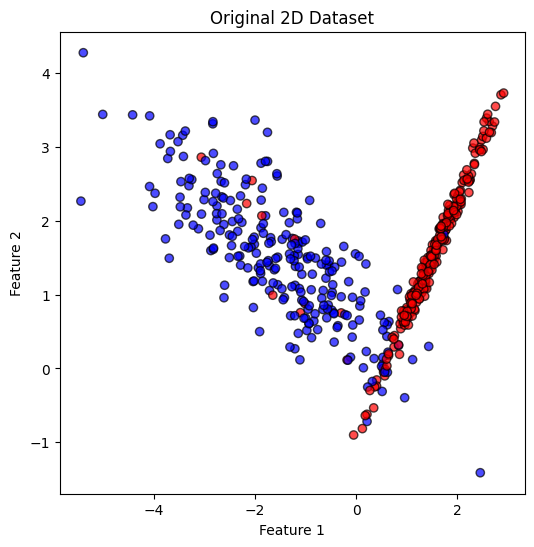

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Set random seed for reproducibility
np.random.seed(42)

# Generate base dataset with 2 informative features
X, y = make_classification(
    n_samples=500,
    n_features=2,  # Start with 2 relevant features
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    flip_y=0.05,  # Small amount of noise
    class_sep=1.5,  # Clear separation between classes
    random_state=42
)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Plot the original 2D data
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7, edgecolors='k')
plt.title("Original 2D Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [3]:
def add_noisy_features(X, num_noisy_features):
    """Add Gaussian noise features to the dataset"""
    n_samples = X.shape[0]
    noise = np.random.normal(loc=0, scale=1, size=(n_samples, num_noisy_features))
    return np.hstack([X, noise])

In [4]:
# Define the range of dimensions to test
max_additional_features = 500
step = 25  # Evaluate every 5 features

# Initialize results storage
results = {
    'knn': [],
    'logistic': [],
    'tree': []
}
dimensions = []

# Initialize classifiers
knn = KNeighborsClassifier(n_neighbors=5)
logistic = LogisticRegression(max_iter=1000, random_state=42, penalty=None)
tree = DecisionTreeClassifier(random_state=42)

for num_noise in tqdm(range(0, max_additional_features + 1, step)):
    # Add noisy features
    X_train_noisy = add_noisy_features(X_train, num_noise)
    X_test_noisy = add_noisy_features(X_test, num_noise)

    dimensions.append(2 + num_noise)  # Total number of features

    # Train and evaluate KNN
    knn.fit(X_train_noisy, y_train)
    y_pred = knn.predict(X_test_noisy)
    results['knn'].append(accuracy_score(y_test, y_pred))

    # Train and evaluate Logistic Regression
    logistic.fit(X_train_noisy, y_train)
    y_pred = logistic.predict(X_test_noisy)
    results['logistic'].append(accuracy_score(y_test, y_pred))

    # Train and evaluate Decision Tree
    tree.fit(X_train_noisy, y_train)
    y_pred = tree.predict(X_test_noisy)
    results['tree'].append(accuracy_score(y_test, y_pred))

100%|██████████| 21/21 [00:02<00:00,  9.75it/s]


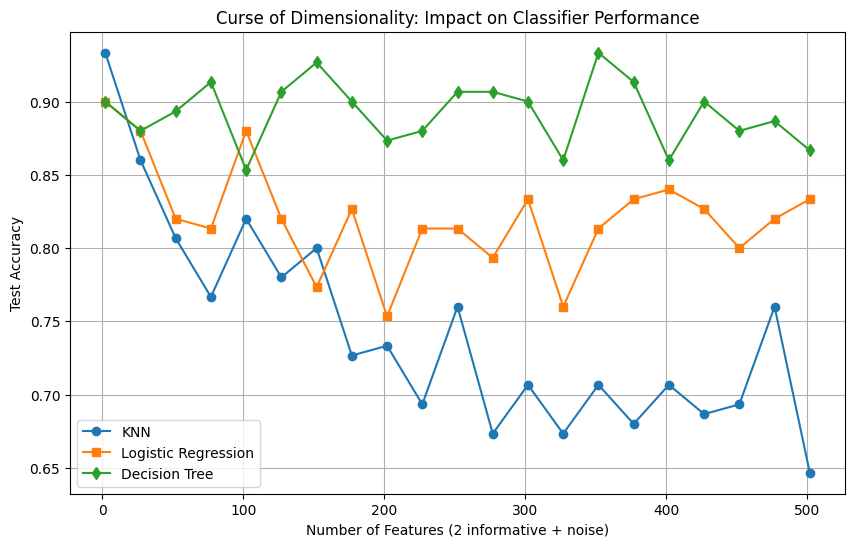

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(dimensions, results['knn'], 'o-', label='KNN')
plt.plot(dimensions, results['logistic'], 's-', label='Logistic Regression')
plt.plot(dimensions, results['tree'], 'd-', label='Decision Tree')
plt.xlabel('Number of Features (2 informative + noise)')
plt.ylabel('Test Accuracy')
plt.title('Curse of Dimensionality: Impact on Classifier Performance')
plt.legend()
plt.grid(True)
plt.show()

# Clustering Techniques Demonstration

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import math

## 1. K-Means Clustering
# A centroid-based algorithm that partitions data into K clusters.

In [8]:
def k_means(X, K, max_iters=100, random_state=None):
    """
    K-means algorithm implementation

    Parameters:
    X : numpy array - Data matrix (n_samples, n_features)
    K : int - Number of clusters
    max_iters : int - Maximum iterations
    random_state : int - Random seed for reproducibility

    Returns:
    centroids : numpy array - Cluster centers
    labels : numpy array - Cluster assignments
    """
    if random_state is not None:
        np.random.seed(random_state)

    # Initialize centroids using random points from dataset
    centroids = X[np.random.choice(X.shape[0], K, replace=False), :]

    for _ in range(max_iters):
        # Assign points to nearest centroid
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)

        # Update centroids
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(K)])

        # Check for convergence
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids

    return centroids, labels

In [9]:
# help(np.allclose)

### K-Means Animation
# Visualizing how centroids evolve over iterations

In [25]:
# Generate sample data
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=42
)

In [26]:
# Set up animation
fig, ax = plt.subplots(figsize=(8, 6))
k = 4
max_iters_range = range(1, 11)  # Show more iterations

def update(frame):
    ax.clear()
    max_iters = max_iters_range[frame]
    centroids, labels = k_means(X, k, max_iters=max_iters, random_state=42)

    # Plot data points
    ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6)

    # Plot centroids
    ax.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, linewidths=2)

    ax.set_title(f'K-Means Clustering (Iteration {max_iters})')
    ax.grid(True)

anim = FuncAnimation(fig, update, frames=len(max_iters_range), interval=1000)
plt.close()

In [27]:
# Display animation
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)

## 2. DBSCAN Clustering
# Density-based algorithm that finds clusters of varying shapes.

In [10]:
def dbscan(X, eps, min_samples):
    """
    DBSCAN clustering implementation

    Parameters:
    X : numpy array - Input data points
    eps : float - Neighborhood radius
    min_samples : int - Minimum points to form a dense region

    Returns:
    labels : numpy array - Cluster assignments (-1 for noise)
    """
    n = X.shape[0]
    visited = np.zeros(n, dtype=bool)
    labels = np.zeros(n, dtype=int) - 1  # Initialize all as noise (-1)
    cluster_id = 0

    def region_query(p):
        return np.where(np.linalg.norm(X - X[p], axis=1) <= eps)[0]

    def expand_cluster(p, neighbors):
        labels[p] = cluster_id
        i = 0
        while i < len(neighbors):
            q = neighbors[i]
            if not visited[q]:
                visited[q] = True
                q_neighbors = region_query(q)
                if len(q_neighbors) >= min_samples:
                    neighbors = np.concatenate((neighbors, q_neighbors))
            if labels[q] == -1:
                labels[q] = cluster_id
            i += 1

    for i in range(n):
        if not visited[i]:
            visited[i] = True
            neighbors = region_query(i)
            if len(neighbors) >= min_samples:
                expand_cluster(i, neighbors)
                cluster_id += 1

    return labels

### DBSCAN on Different Dataset Types

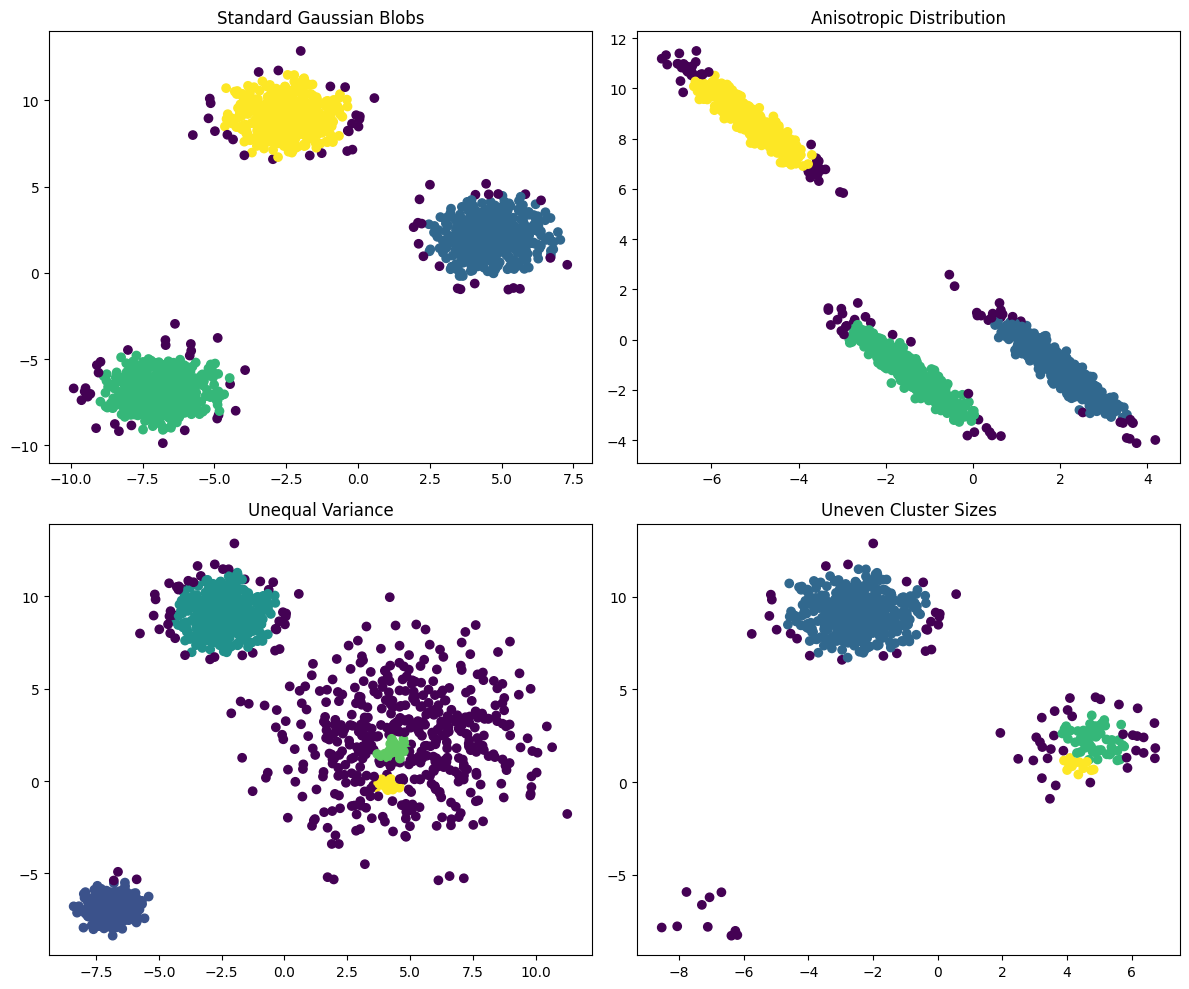

In [29]:
# Generate different dataset types
n_samples = 1500
random_state = 42

# 1. Standard blobs
X1, y1 = make_blobs(n_samples=n_samples, random_state=random_state)

# 2. Anisotropic blobs
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X2 = np.dot(X1, transformation)

# 3. Unequal variance
X3, y3 = make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

# 4. Unevenly sized
X4 = np.vstack((X1[y1 == 0][:500], X1[y1 == 1][:100], X1[y1 == 2][:10]))

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Standard blobs
labels = dbscan(X1, 0.5, 10)
axs[0, 0].scatter(X1[:, 0], X1[:, 1], c=labels, cmap='viridis')
axs[0, 0].set_title("Standard Gaussian Blobs")

# Anisotropic blobs
labels = dbscan(X2, 0.3, 15)
axs[0, 1].scatter(X2[:, 0], X2[:, 1], c=labels, cmap='viridis')
axs[0, 1].set_title("Anisotropic Distribution")

# Unequal variance
labels = dbscan(X3, 0.5, 15)
axs[1, 0].scatter(X3[:, 0], X3[:, 1], c=labels, cmap='viridis')
axs[1, 0].set_title("Unequal Variance")

# Uneven sizes
labels = dbscan(X4, 0.5, 10)
axs[1, 1].scatter(X4[:, 0], X4[:, 1], c=labels, cmap='viridis')
axs[1, 1].set_title("Uneven Cluster Sizes")

plt.tight_layout()
plt.show()

## 3. Time Series Clustering with DTW
# Using tslearn for time series clustering with Dynamic Time Warping.

In [31]:
!pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.0 MB/s eta 0:00:00


In [145]:
import yfinance as yf
import pandas as pd
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.metrics import cdist_dtw

In [146]:
pd.set_option("display.max_columns", None)

In [154]:
# Fetch stock data
def get_sp500_data():
    payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    df = pd.DataFrame(payload[0])
    tickers = df['Symbol'].values.tolist()
    data = yf.download(tickers, start='2020-07-01', end='2020-12-31')['Close']

    data.dropna(axis=1, inplace=True)
    return data

# Preprocess data
def preprocess_data(data):
    # Standardize each time series
    return pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns)

In [155]:
# Load and prepare data
data = get_sp500_data()

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
10 Failed downloads:
ERROR:yfinance:['VLTO', 'GEV', 'SOLV', 'GEHC', 'SW', 'EXE', 'CEG', 'KVUE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-01 -> 2020-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1593576000, endDate = 1609390800")')
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-07-01 -> 2020-12-31)')
ERROR:yfinance:['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


In [156]:
data_scaled = preprocess_data(data)
time_series = to_time_series_dataset(data_scaled.T)

Calculating silhouette scores...


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
 33%|███▎      | 1/3 [02:25<04:50, 145.31s/it]

k=2: Silhouette score = 0.449


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
 67%|██████▋   | 2/3 [04:27<02:11, 131.73s/it]

k=3: Silhouette score = 0.326


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
100%|██████████| 3/3 [07:59<00:00, 160.00s/it]

k=4: Silhouette score = 0.312


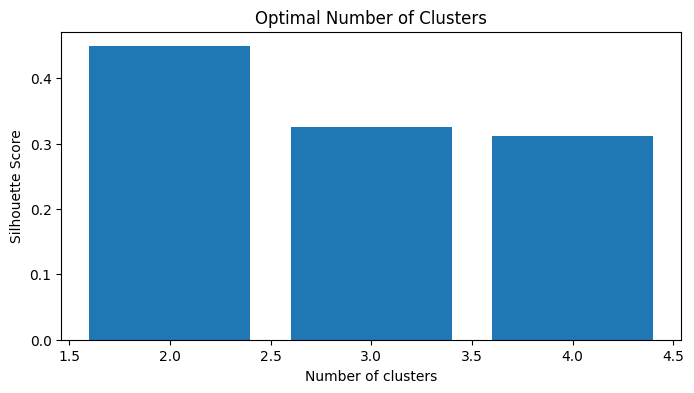

In [157]:
# Calculate silhouette scores for different cluster counts
cluster_range = range(2, 5)
silhouettes = []

print("Calculating silhouette scores...")
for k in tqdm(cluster_range):
    km = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_init=3)
    labels = km.fit_predict(time_series)
    score = silhouette_score(time_series, labels, metric="dtw")
    silhouettes.append(score)
    print(f"k={k}: Silhouette score = {score:.3f}")

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.bar(cluster_range, silhouettes)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Clusters')
plt.show()

In [158]:
# Fit final model with optimal k
optimal_k = cluster_range[np.argmax(silhouettes)]
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 2


In [159]:
km = TimeSeriesKMeans(n_clusters=optimal_k, metric="dtw")
labels = km.fit_predict(time_series)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


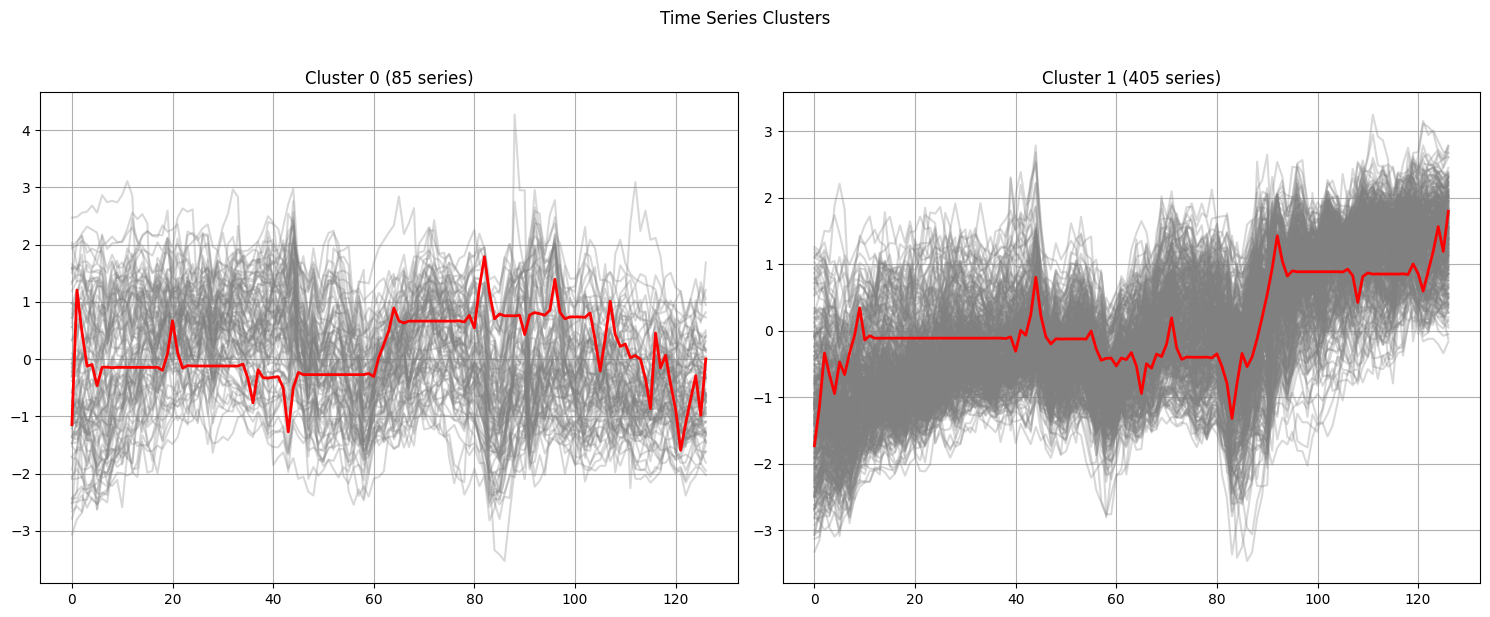

In [160]:
# Visualize clusters
fig, axs = plt.subplots(math.ceil(optimal_k/2), 2, figsize=(15, 3*optimal_k), squeeze=False)
fig.suptitle('Time Series Clusters', y=1.02)

for cluster_id in range(optimal_k):
    row = cluster_id // 2
    col = cluster_id % 2

    # Plot all series in cluster
    cluster_series = time_series[labels == cluster_id]
    for series in cluster_series:
        axs[row, col].plot(series.ravel(), c='gray', alpha=0.3)

    # Plot cluster centroid
    if len(cluster_series) > 0:
        centroid = km.cluster_centers_[cluster_id].ravel()
        axs[row, col].plot(centroid, c='red', linewidth=2)

    axs[row, col].set_title(f'Cluster {cluster_id} ({len(cluster_series)} series)')
    axs[row, col].grid(True)

# Hide any empty subplots
for i in range(optimal_k, math.ceil(optimal_k/2)*2):
    row = i // 2
    col = i % 2
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

# PCA for signal processing

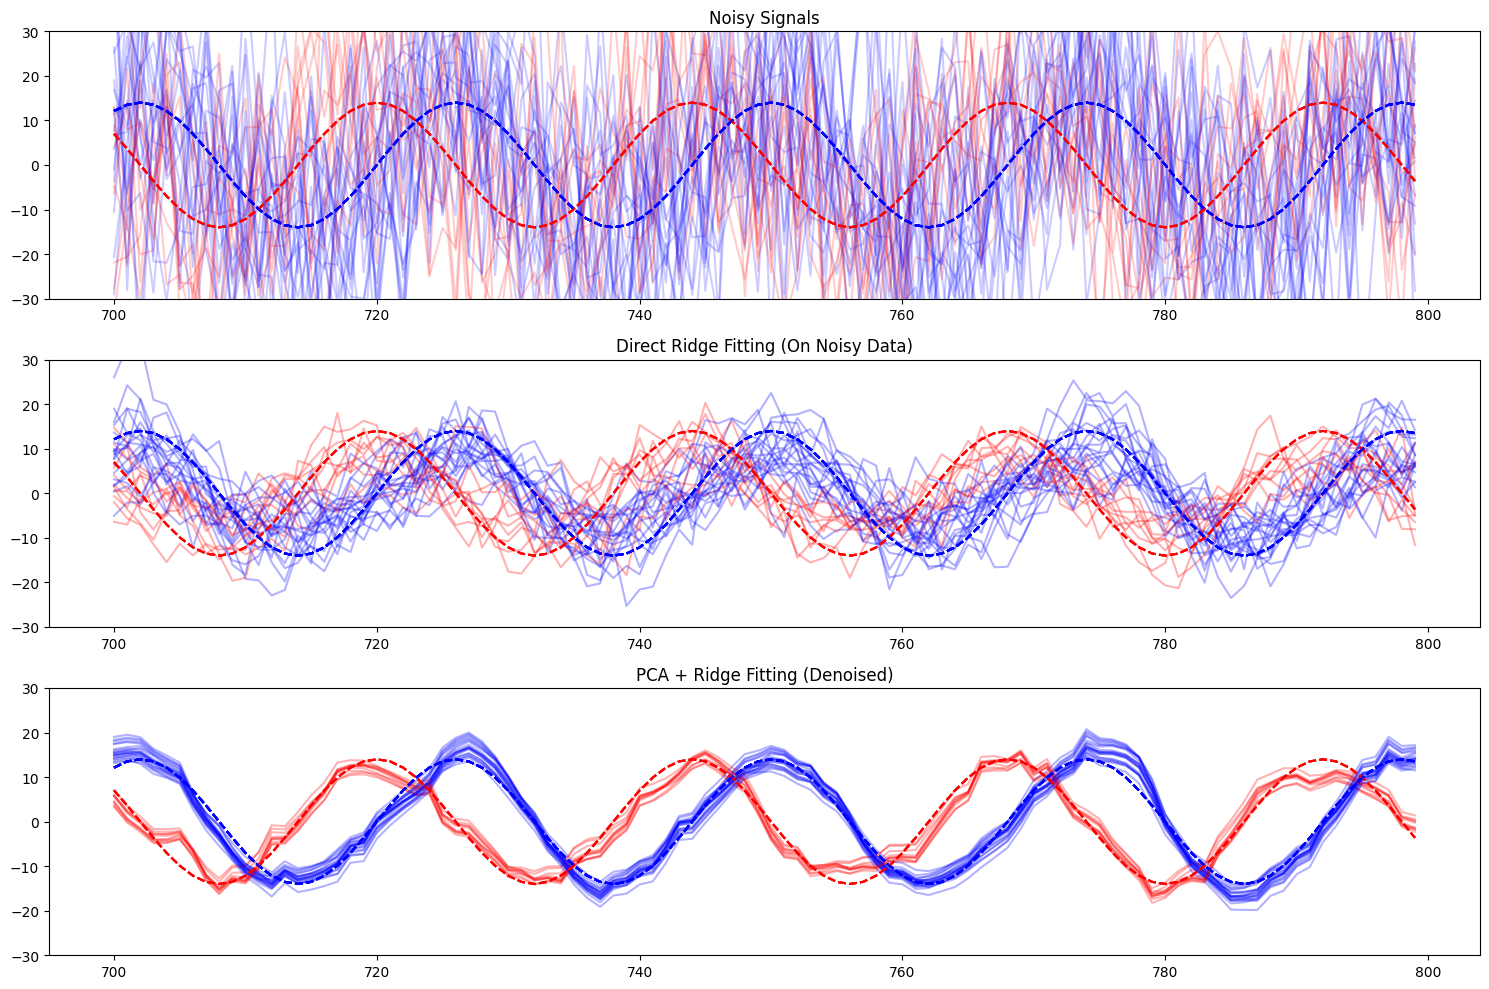

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Generate both noisy and clean sinusoidal data
def gen_sinusoidal(timesteps, amp, freq, noise, kind='sin', random_state=0):
    np.random.seed(random_state)
    X = np.arange(timesteps)
    e = np.random.normal(0, noise, (timesteps,))
    if kind == 'sin':
        y_noisy = amp*np.sin(X*(2*np.pi/freq)) + e
        y_clean = amp*np.sin(X*(2*np.pi/freq))
    elif kind == 'cos':
        y_noisy = amp*np.cos(X*(2*np.pi/freq)) + e
        y_clean = amp*np.cos(X*(2*np.pi/freq))
    return y_noisy, y_clean

n_series, timesteps = 30, 800
df_noisy = pd.DataFrame()
df_clean = pd.DataFrame()

for i in range(n_series):
    noisy, clean = gen_sinusoidal(
        timesteps, amp=14, freq=24, noise=20,
        kind=('sin' if i%3 > 0 else 'cos'),
        random_state=i)
    df_noisy[f'ts_{i}'] = noisy
    df_clean[f'ts_{i}'] = clean

# Prepare lag features
def add_lags(data, max_lag=12):
    for lag in range(1, max_lag+1):
        data[f"lag_{lag}"] = data.y.shift(lag)
    return data.dropna()

# Direct Ridge fits on noisy data
direct_preds = []
for i in range(n_series):
    data = pd.DataFrame(df_noisy[f"ts_{i}"].values, columns=["y"])
    data = add_lags(data)
    X, y = data.drop(columns=["y"]), data["y"]
    model = Ridge(alpha=1).fit(X, y)
    direct_preds.append(model.predict(X))

# PCA + Ridge fits
scaler_pca = make_pipeline(StandardScaler(), PCA(n_components=2))
df_pca = scaler_pca.fit_transform(df_noisy)
reconstructed = scaler_pca.inverse_transform(df_pca)

pca_preds = []
for i in range(n_series):
    data = pd.DataFrame(reconstructed[:, i], columns=["y"])
    data = add_lags(data)
    X, y = data.drop(columns=["y"]), data["y"]
    model = Ridge(alpha=1).fit(X, y)
    pca_preds.append(model.predict(X))

# Visualization
plt.figure(figsize=(15, 10))


plt.subplot(3, 1, 1)
for i in range(n_series):
    color = 'blue' if i%3 > 0 else 'red'
    plt.plot(df_noisy.index[-100:], df_noisy.iloc[-100:, i],
             color=color, alpha=0.2)
for i in range(n_series):
    color = 'blue' if i%3 > 0 else 'red'
    plt.plot(df_clean.index[-100:], df_clean.iloc[-100:, i],
             color=color, alpha=0.4, linestyle='--')
plt.ylim([-30, 30])
plt.title("Noisy Signals")

# Plot direct Ridge predictions
plt.subplot(3, 1, 2)
for i, pred in enumerate(direct_preds):
    color = 'blue' if i%3 > 0 else 'red'
    pred_idx = df_noisy.index[-len(pred):][-100:]
    plt.plot(pred_idx, pred[-100:], color=color, alpha=0.3)
for i in range(n_series):
    color = 'blue' if i%3 > 0 else 'red'
    plt.plot(df_clean.index[-100:], df_clean.iloc[-100:, i],
             color=color, alpha=0.4, linestyle='--')
plt.ylim([-30, 30])
plt.title("Direct Ridge Fitting (On Noisy Data)")

# Plot PCA + Ridge predictions
plt.subplot(3, 1, 3)
for i, pred in enumerate(pca_preds):
    color = 'blue' if i%3 > 0 else 'red'
    pred_idx = df_noisy.index[-len(pred):][-100:]
    plt.plot(pred_idx, pred[-100:], color=color, alpha=0.3)
for i in range(n_series):
    color = 'blue' if i%3 > 0 else 'red'
    plt.plot(df_clean.index[-100:], df_clean.iloc[-100:, i],
             color=color, alpha=0.4, linestyle='--')
plt.ylim([-30, 30])
plt.title("PCA + Ridge Fitting (Denoised)")

plt.tight_layout()
plt.show()